In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('./out_csv/combined_SEQpower.csv')

In [3]:
# Define the sigmoid function for curve fitting
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Function to find OR for a given power level
def find_or_for_power(params, target_power):
    L, x0, k, b = params
    # Using the inverse of the sigmoid function
    if target_power <= b or target_power >= L + b:
        return None  # Target power outside the range of the sigmoid
    return x0 - (1/k) * np.log((L / (target_power - b)) - 1)

In [4]:
# Group by sample size (ncases)
# sample_sizes = df['ncases'].unique()

In [10]:
df['ncases'] = df['ncases'].apply(lambda x: 964 if x==963 else x)

In [11]:
sample_sizes = df['ncases'].unique()

In [12]:
# sample_sizes = np.array([964, 1256])

Sample size: 1256 cases
  Fitted sigmoid: power = 1.0914 / (1 + exp(-5.4896 * (OR - 1.3501))) + -0.1008
  OR for 85% power: 1.6983
  OR for 95% power: 1.9427
Sample size: 964 cases
  Fitted sigmoid: power = 1.0640 / (1 + exp(-5.0753 * (OR - 1.3904))) + -0.0885
  OR for 85% power: 1.7866
  OR for 95% power: 2.1200


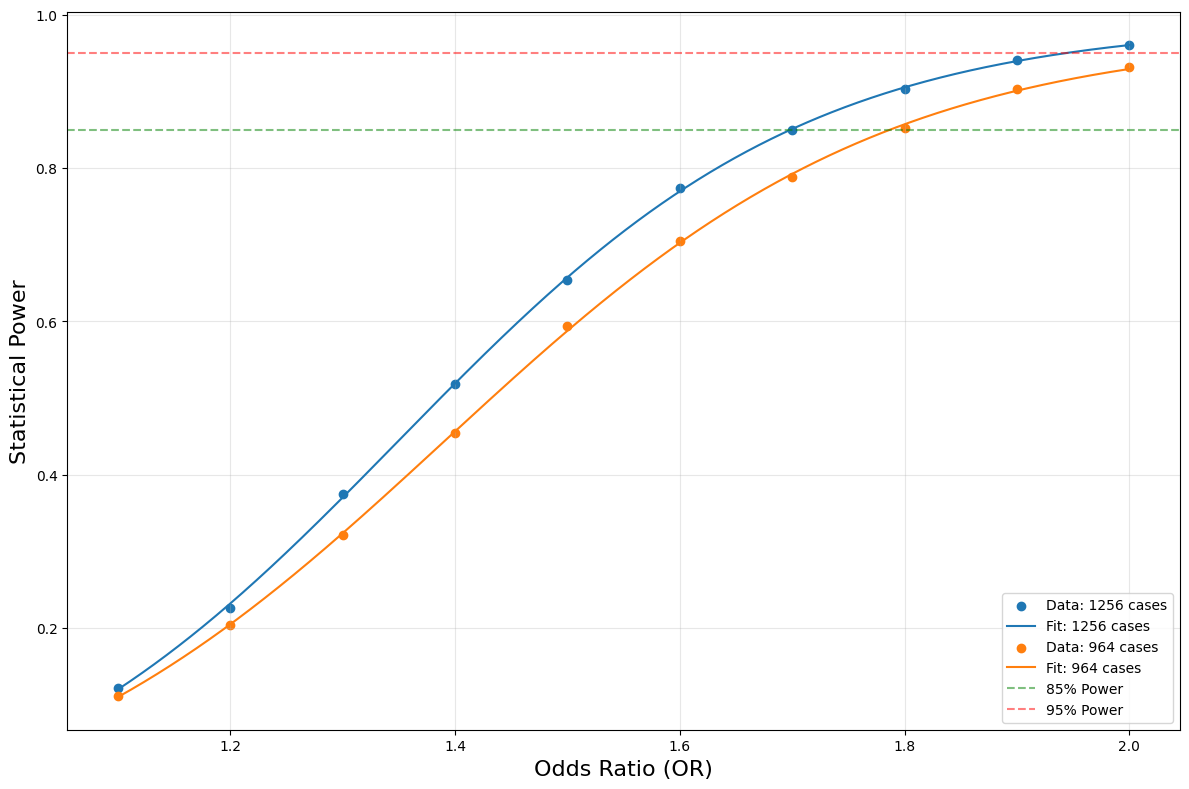

In [14]:
plt.figure(figsize=(12, 8))

for sample_size in sample_sizes:
    subset = df[df['ncases'] == sample_size]
    
    # Group by OR and calculate average power
    or_power = subset.groupby('_or_rare_detrimental')['power'].mean().reset_index()
    or_values = or_power['_or_rare_detrimental'].values
    power_values = or_power['power'].values
    
    # Sort by OR for better plotting
    idx = np.argsort(or_values)
    or_values = or_values[idx]
    power_values = power_values[idx]
    
    # Curve fitting
    try:
        # Initial parameter guesses
        p0 = [1, 1.5, 5, 0] 
        params, _ = curve_fit(sigmoid, or_values, power_values, p0=p0, maxfev=10000)
        L, x0, k, b = params
        
        # Create a smoother curve for plotting
        or_smooth = np.linspace(min(or_values), max(or_values), 1000)
        power_smooth = sigmoid(or_smooth, L, x0, k, b)
        
        # Find the OR values for 85% and 95% power
        or_85 = find_or_for_power(params, 0.85)
        or_95 = find_or_for_power(params, 0.95)
        
        # Plot data and fitted curve
        plt.scatter(or_values, power_values, label=f'Data: {sample_size} cases')
        plt.plot(or_smooth, power_smooth, label=f'Fit: {sample_size} cases')
        
        # Add reference lines for 85% and 95% power levels
#         if or_85 is not None:
#             plt.axvline(x=or_85, linestyle='--', alpha=0.5, color='green')
#             plt.text(or_85, 0.2, f'{or_85:.2f}', rotation=90, color='green')
            
#         if or_95 is not None:
#             plt.axvline(x=or_95, linestyle='--', alpha=0.5, color='red')
#             plt.text(or_95, 0.3, f'{or_95:.2f}', rotation=90, color='red')
        
        print(f"Sample size: {sample_size} cases")
        print(f"  Fitted sigmoid: power = {L:.4f} / (1 + exp(-{k:.4f} * (OR - {x0:.4f}))) + {b:.4f}")
        print(f"  OR for 85% power: {or_85:.4f}")
        print(f"  OR for 95% power: {or_95:.4f}")
        
    except Exception as e:
        print(f"Error fitting curve for sample size {sample_size}: {e}")
        plt.scatter(or_values, power_values, label=f'Data: {sample_size} cases')
        plt.plot(or_values, power_values, '--', label=f'Raw: {sample_size} cases')

# Add horizontal lines for 85% and 95% power
plt.axhline(y=0.85, linestyle='--', color='green', alpha=0.5, label='85% Power')
plt.axhline(y=0.95, linestyle='--', color='red', alpha=0.5, label='95% Power')

plt.xlabel('Odds Ratio (OR)', fontsize=16)
plt.ylabel('Statistical Power', fontsize=16)
# plt.title('Statistical Power vs. Odds Ratio by Sample Size', fontsize=24)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('power_simulation.png')
plt.show()